### Results

This notebook contains visualizations for the results csv

- Threads x Speedup
- Threads x Efficiency
- Overhead bars
- Solution quality

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
project_root = os.path.abspath('..')
data_path = os.path.join(project_root, 'results', 'data.csv')

In [3]:
df = pd.read_csv(data_path)
df.head()

,instance,size,mode,threads,time_ms,best_distance
0,a280,280,sequential,1,1929.0205,2761.0623
1,a280,280,sequential,1,1569.3539,2779.7345
2,a280,280,sequential,1,1566.2409,2728.0477
3,a280,280,sequential,1,1527.5250,2717.1654
4,a280,280,parallel,1,1562.2862,2753.3009


In [4]:
instances = df['instance'].unique()
thread_counts = sorted(df[df['mode'] == 'parallel']['threads'].unique())

In [5]:
grouped = df.groupby(['instance', 'mode', 'threads'], sort=False).agg({
    'time_ms': 'mean',
    'best_distance': 'mean'
}).reset_index()

sequential_baselines = grouped[grouped['mode'] == 'sequential'].set_index('instance')['time_ms']

grouped['speedup'] = grouped['instance'].map(sequential_baselines) / grouped['time_ms']
grouped['efficiency'] = (grouped['speedup'] / grouped['threads']) * 100

parallel_data = grouped[grouped['mode'] == 'parallel'].copy()
parallel_data['sequential_time'] = parallel_data['instance'].map(sequential_baselines)
parallel_data['ideal_time'] = parallel_data['sequential_time'] / parallel_data['threads']
parallel_data['overhead'] = parallel_data['time_ms'] - parallel_data['ideal_time']

parallel_data.head()

,instance,mode,threads,time_ms,best_distance,speedup,efficiency,sequential_time,ideal_time,overhead
1,a280,parallel,1,1689.132700,2731.016543,1.010600,101.059953,1707.036713,1707.036713,-17.904013
2,a280,parallel,2,1118.912250,2725.182250,1.525622,76.281081,1707.036713,853.518356,265.393894
3,a280,parallel,4,917.684017,2742.866583,1.860157,46.503935,1707.036713,426.759178,490.924839
4,a280,parallel,8,859.265167,2728.962733,1.986624,24.832799,1707.036713,213.379589,645.885578
5,a280,parallel,16,1031.525950,2726.824750,1.654866,10.342909,1707.036713,106.689795,924.836155


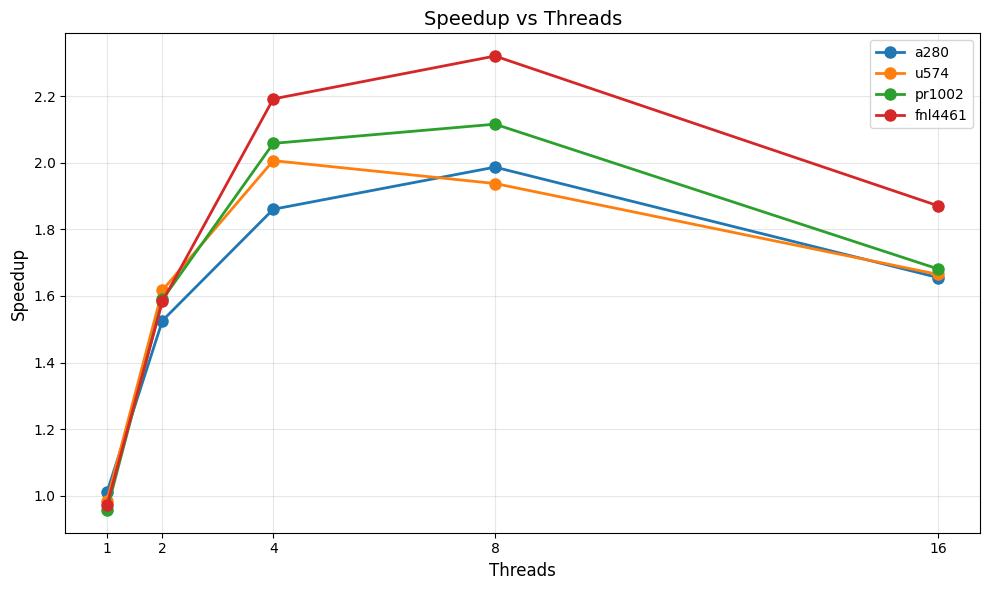

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['speedup'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Speedup vs Número de Threads', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

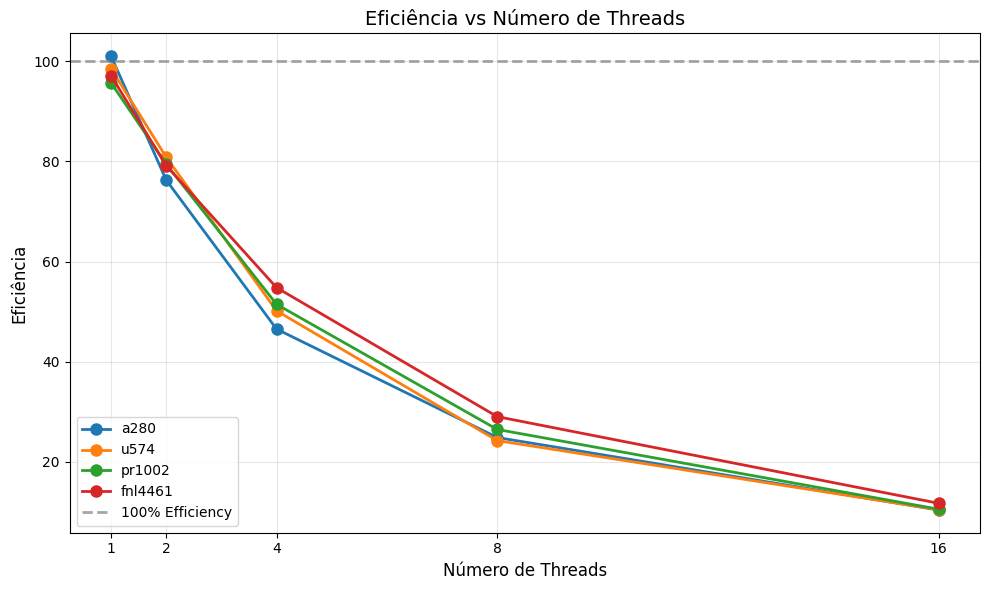

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['efficiency'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)
    
ax.axhline(y=100, 
        linestyle='--', 
        linewidth=2,
        color='gray', 
        alpha=0.7,
        label='100% Efficiency')

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Eficiência', fontsize=12)
ax.set_title('Eficiência vs Número de Threads', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

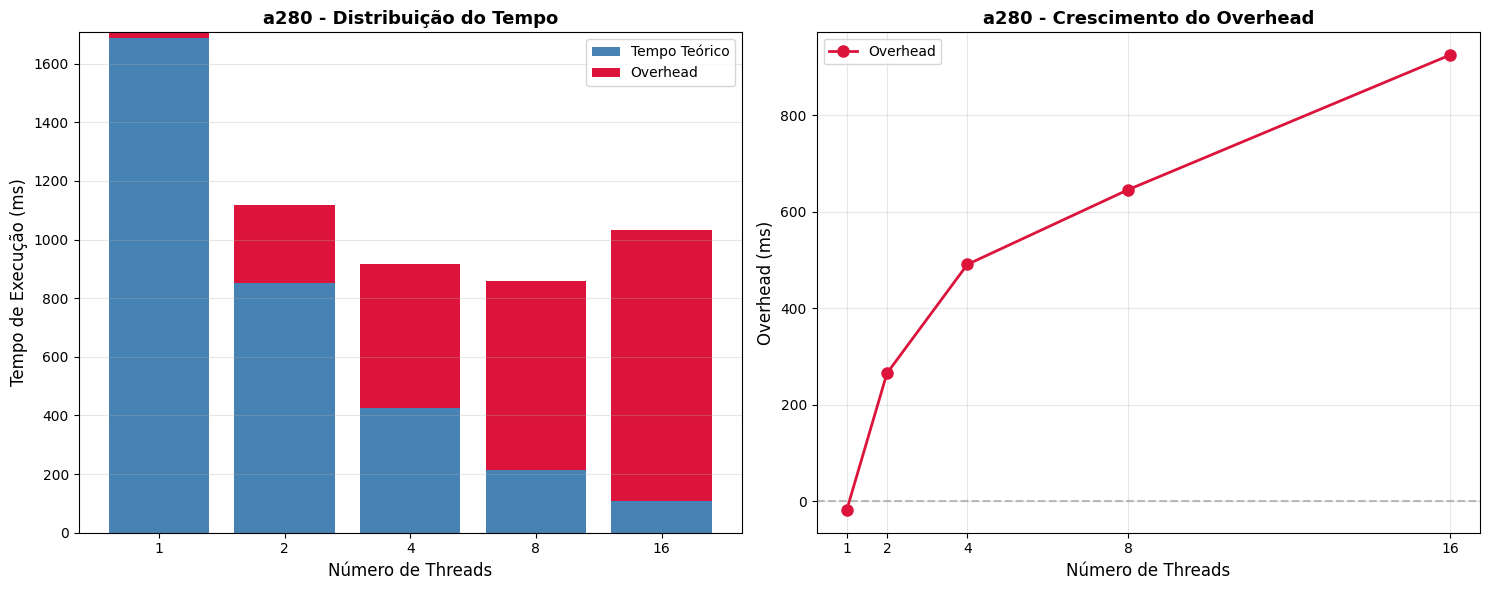

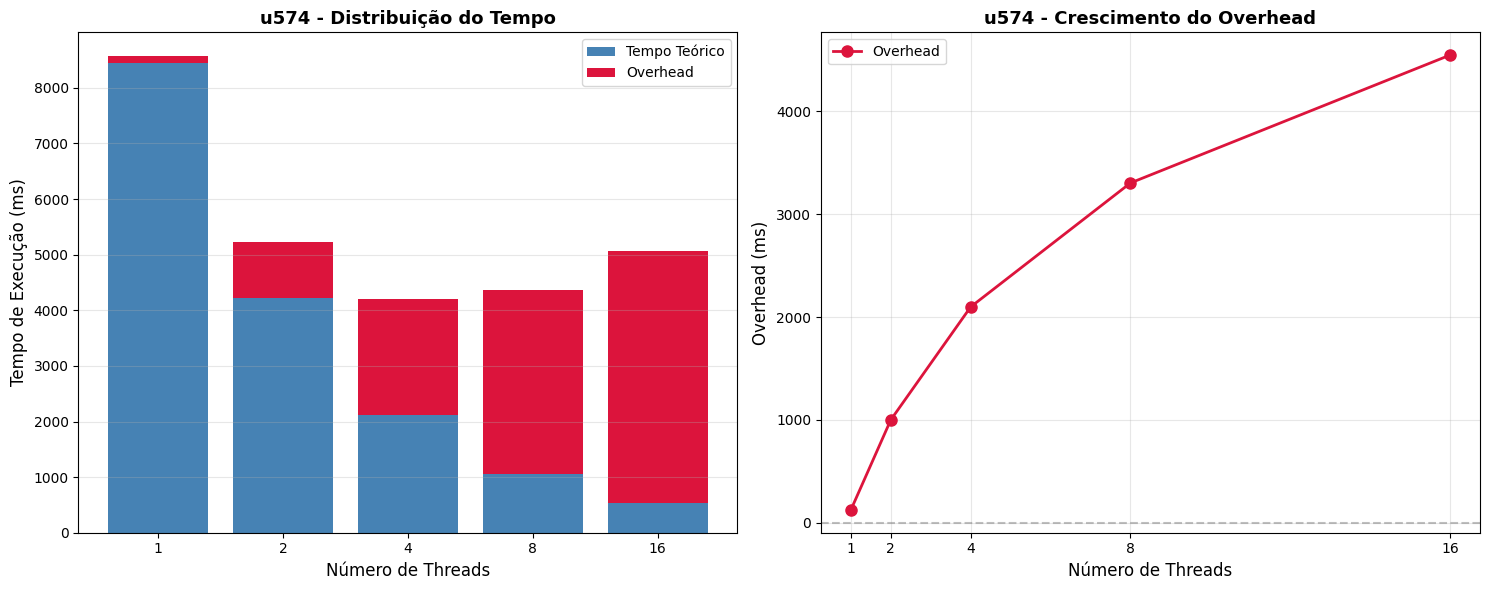

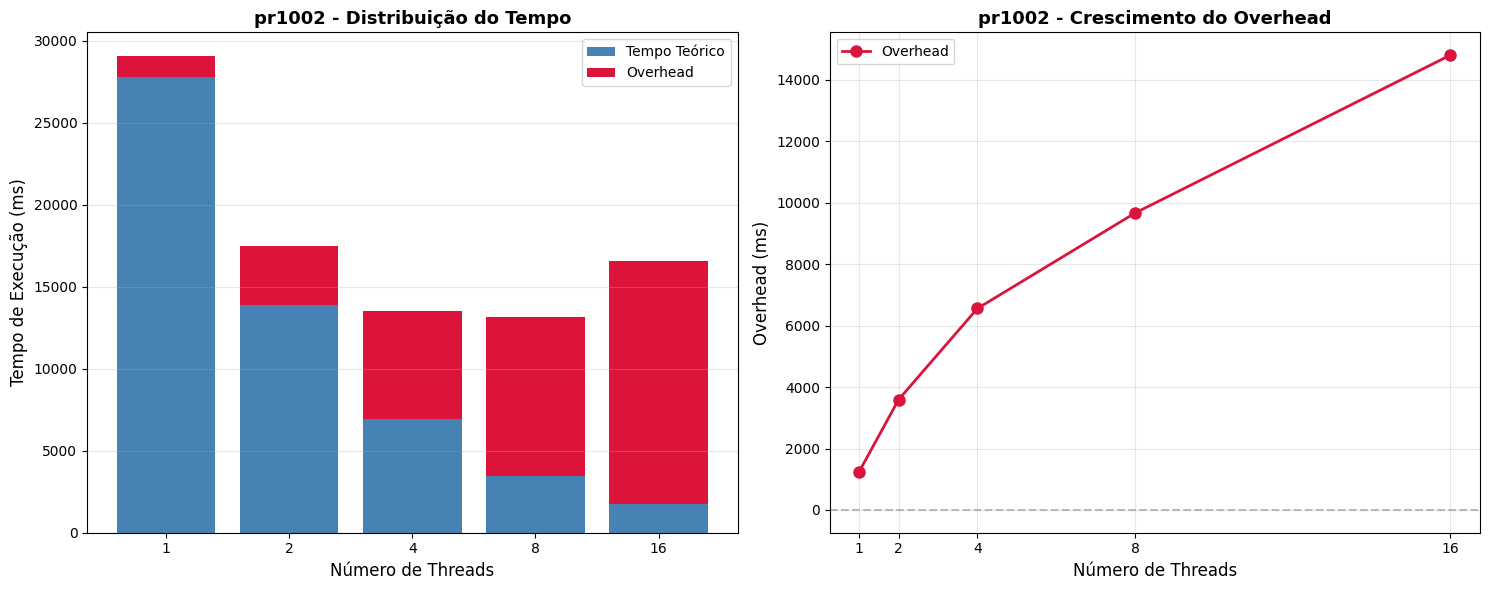

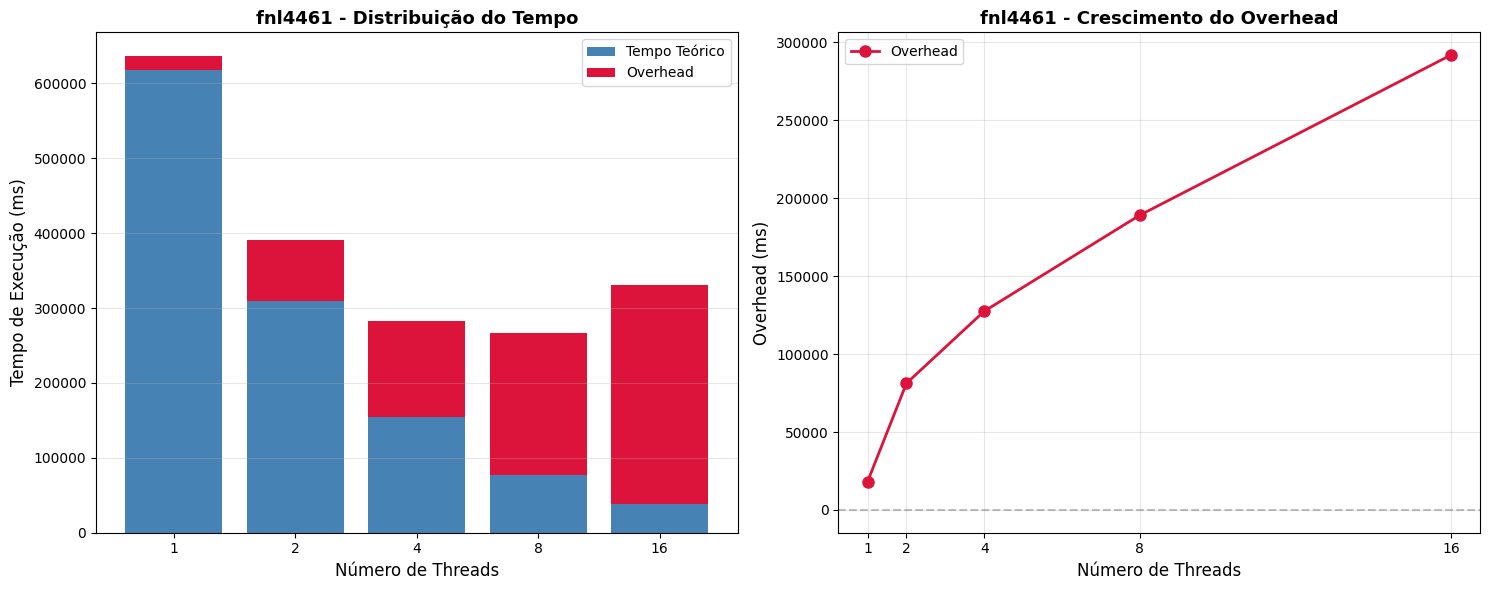

In [8]:
for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    if len(instance_data) == 0:
        print(f"Skipping {instance}: no parallel data")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    threads = instance_data['threads'].values
    ideal = instance_data['ideal_time'].values
    overhead = instance_data['overhead'].values
    
    x_pos = range(len(threads))
    
    # ===== PLOT 1: Stacked Bar Chart =====
    ax1.bar(x_pos, ideal, label='Tempo Teórico', color='steelblue')
    ax1.bar(x_pos, overhead, bottom=ideal, label='Overhead', color='crimson')
    
    ax1.set_xlabel('Número de Threads', fontsize=12)
    ax1.set_ylabel('Tempo de Execução (ms)', fontsize=12)
    ax1.set_title(f'{instance} - Distribuição do Tempo', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(threads)
    
    # ===== PLOT 2: Overhead Line Graph =====
    ax2.plot(threads, overhead,
             marker='o',
             linewidth=2,
             markersize=8,
             color='crimson',
             label='Overhead')
    
    ax2.set_xlabel('Número de Threads', fontsize=12)
    ax2.set_ylabel('Overhead (ms)', fontsize=12)
    ax2.set_title(f'{instance} - Crescimento do Overhead', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(threads)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

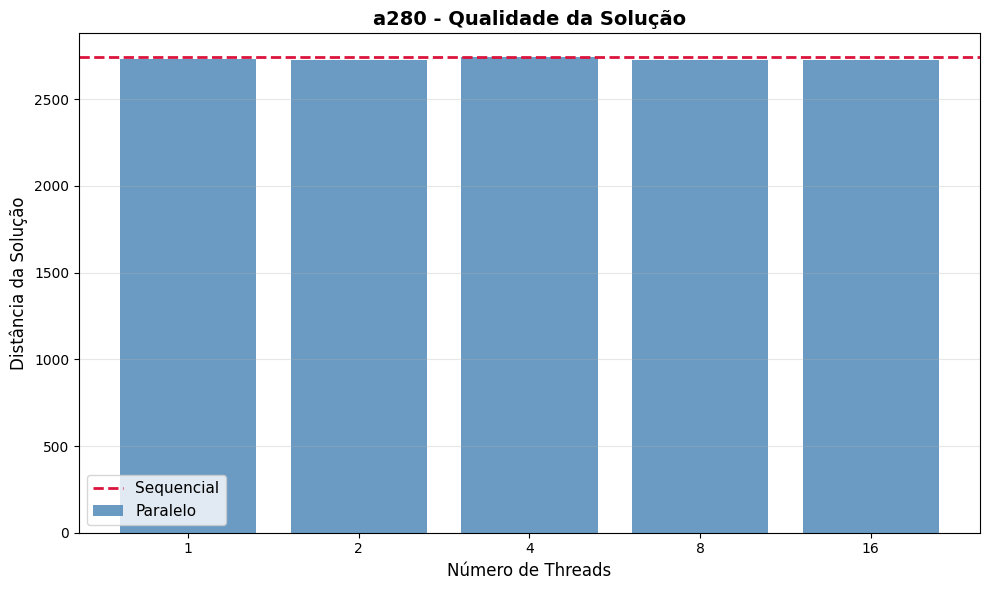

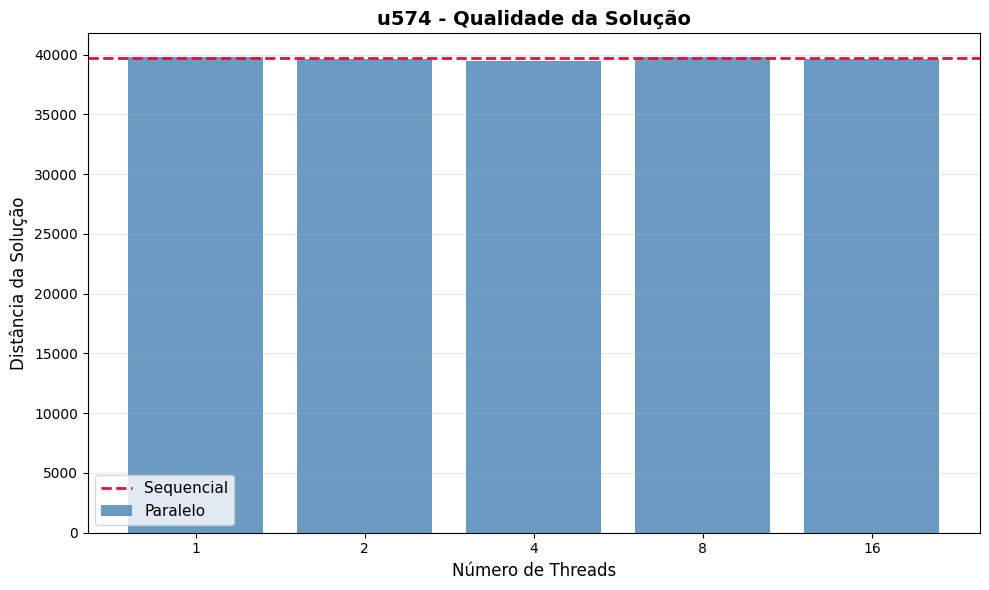

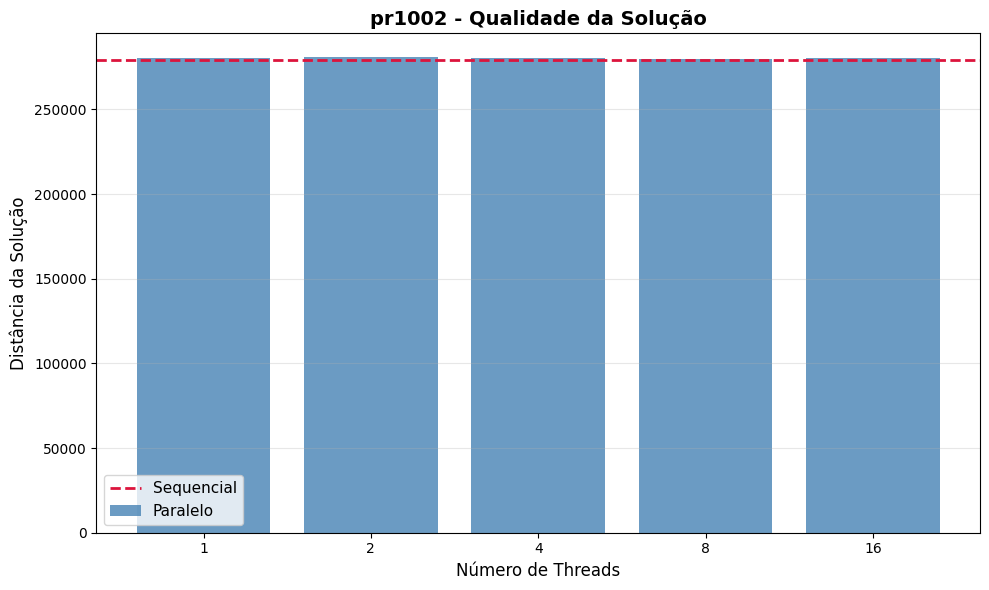

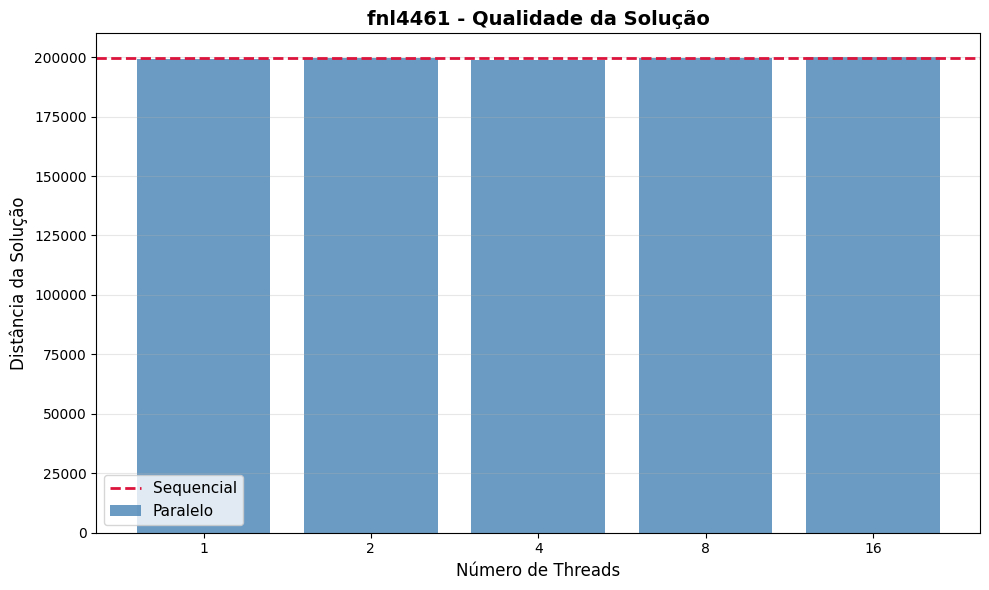

In [9]:
for instance in instances:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    instance_data = grouped[grouped['instance'] == instance]
    seq_data = instance_data[instance_data['mode'] == 'sequential']
    par_data = instance_data[instance_data['mode'] == 'parallel']
    
    seq_distance = seq_data['best_distance'].values[0]
    
    threads = par_data['threads'].values
    par_distances = par_data['best_distance'].values
    
    x_pos = range(len(threads))
    
    ax.bar(x_pos, par_distances, color='steelblue', alpha=0.8, label='Paralelo')
    
    ax.axhline(y=seq_distance, color='crimson', linestyle='--', 
               linewidth=2, label='Sequencial')
    
    ax.set_xlabel('Número de Threads', fontsize=12)
    ax.set_ylabel('Distância da Solução', fontsize=12)
    ax.set_title(f'{instance} - Qualidade da Solução', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(threads)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()